<a href="https://colab.research.google.com/github/KarsonLeperi/DataScienceProjects/blob/main/Time%20series/ts_machineLearning_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Going through the time series forecasting youtube video (Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption). Using machine learning to predict energy data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import io
from google.colab import files

from sklearn.metrics import mean_squared_error

In [2]:
 uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['AEP_hourly.csv']))
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', inplace=True) #The data is not sorted in the csv file (discovered during later analysis). This will clean it up
df = df.set_index('Datetime')
df.head(10)

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
2004-10-01 06:00:00,12280.0
2004-10-01 07:00:00,13692.0
2004-10-01 08:00:00,14618.0
2004-10-01 09:00:00,14903.0


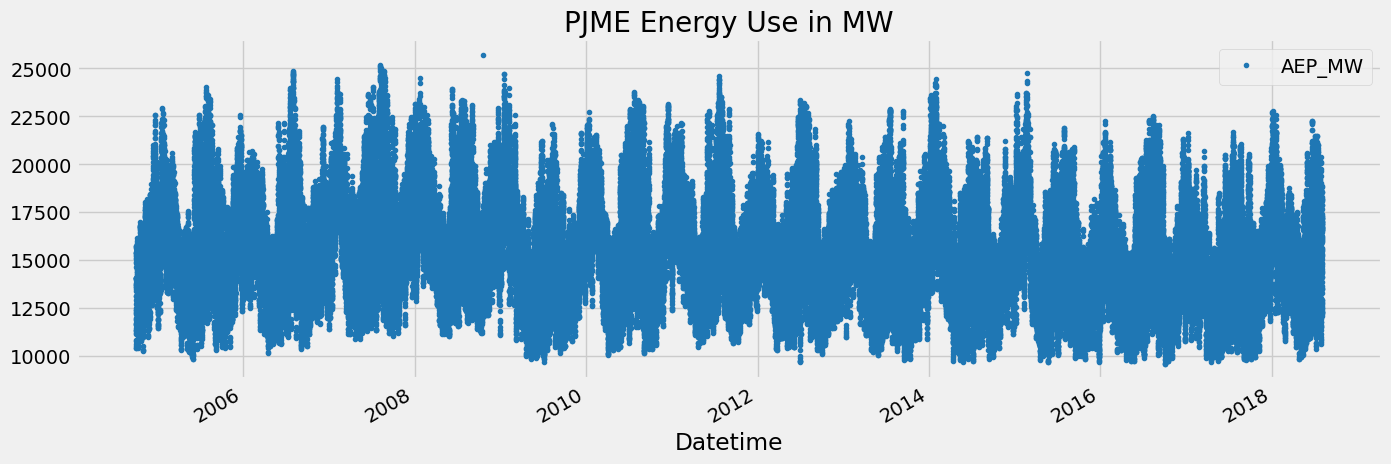

In [4]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#Train/Test Split

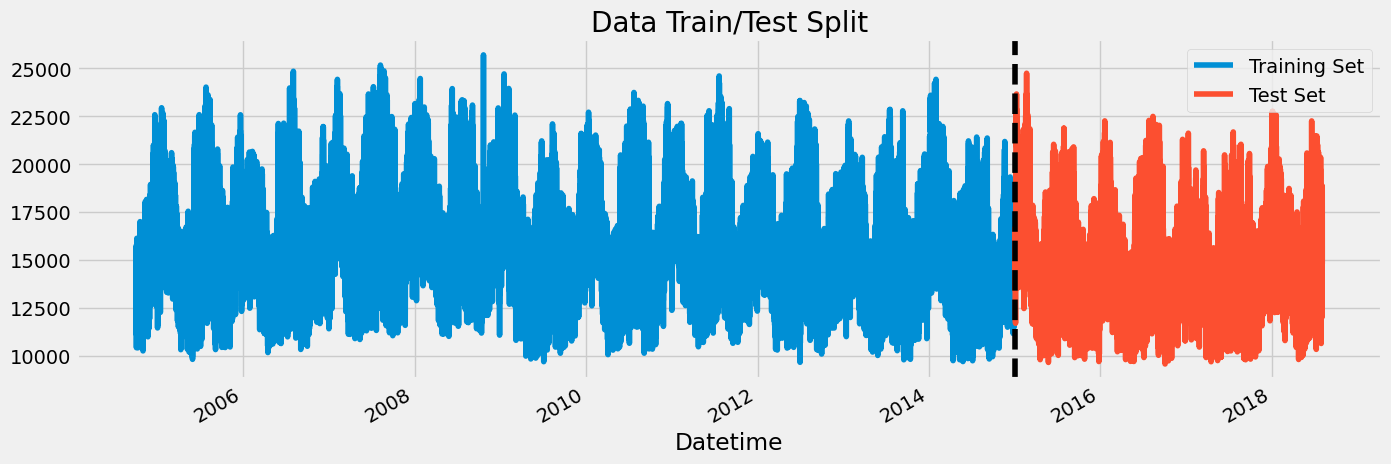

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

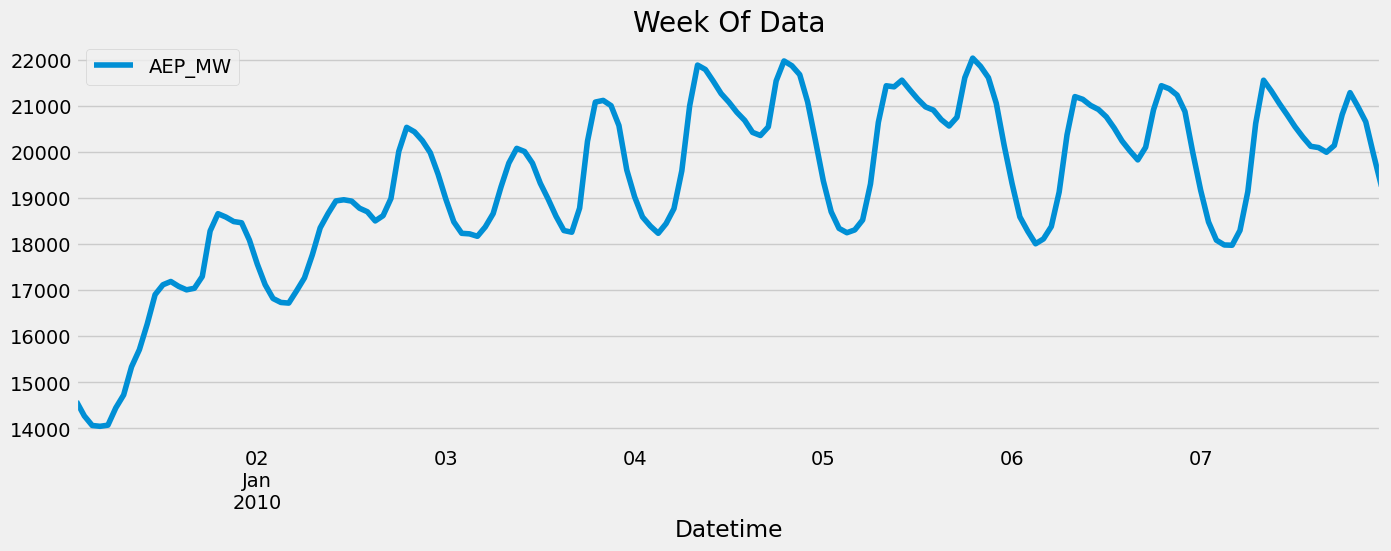

In [6]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

#Feature Creation

In [7]:
def create_features(df):
  """
  Create time series features based on time series index.
  """
  df = df.copy()

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week

  return df

df = create_features(df)
df.head()


,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,1,40
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,1,40
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,1,40
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,1,40
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,1,40


#Visualize Feature

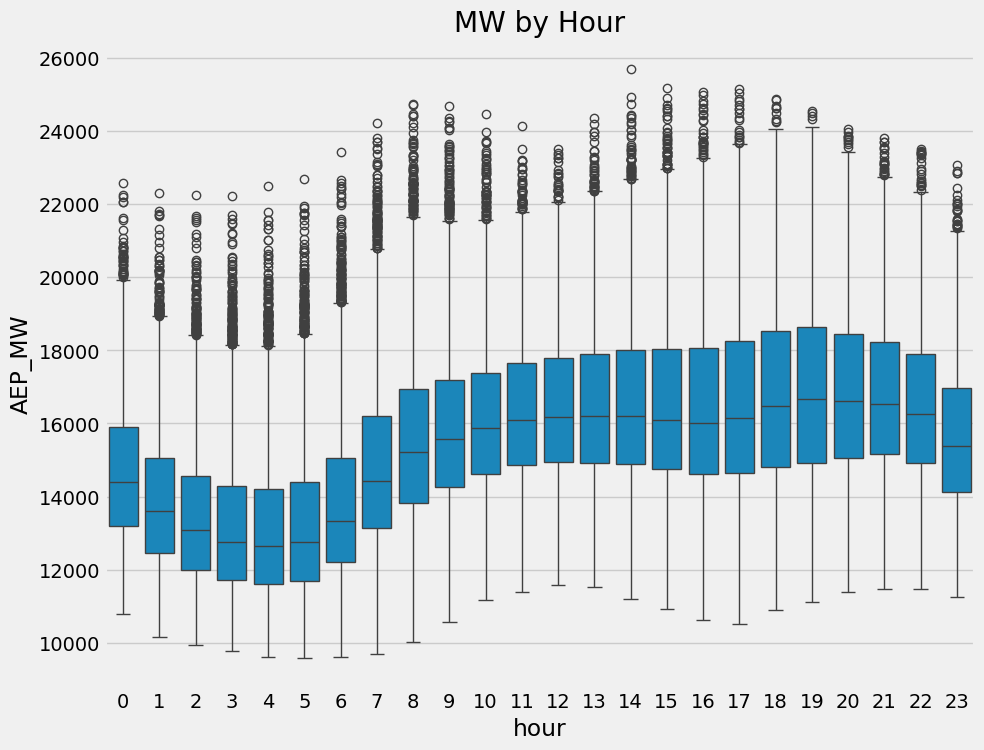

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

/tmp/ipython-input-1997979185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW',palette='Blues')


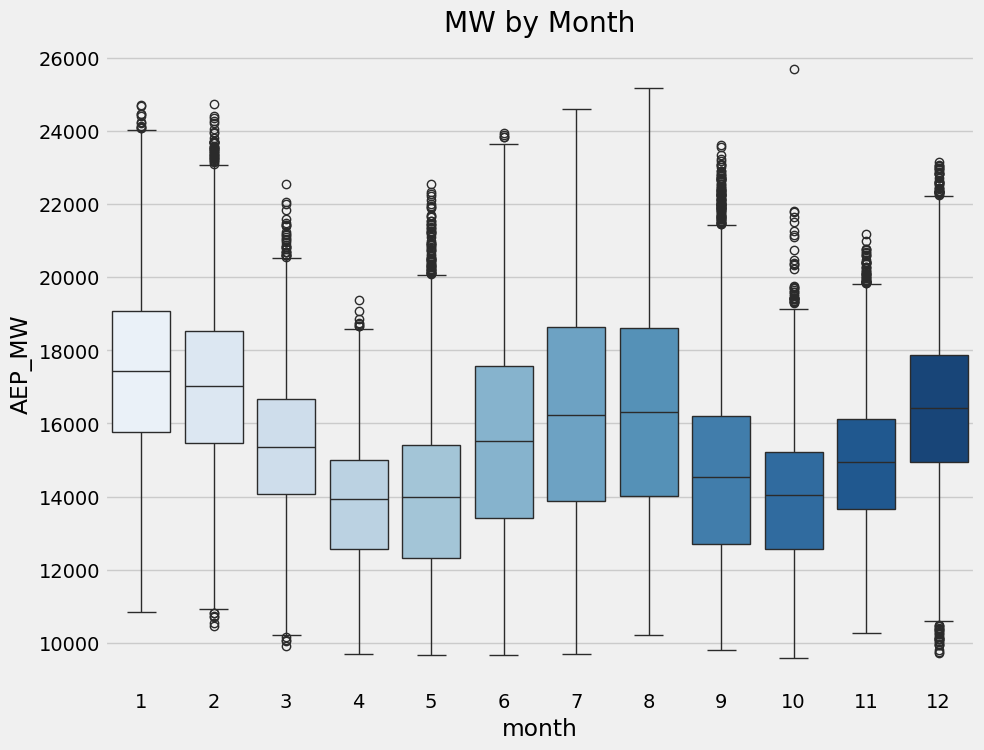

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

#Create Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.94367
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.32523
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1643.19503
[545]	validation_0-rmse:1091.20163	validation_1-rmse:1646.54135


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#Feature Importance

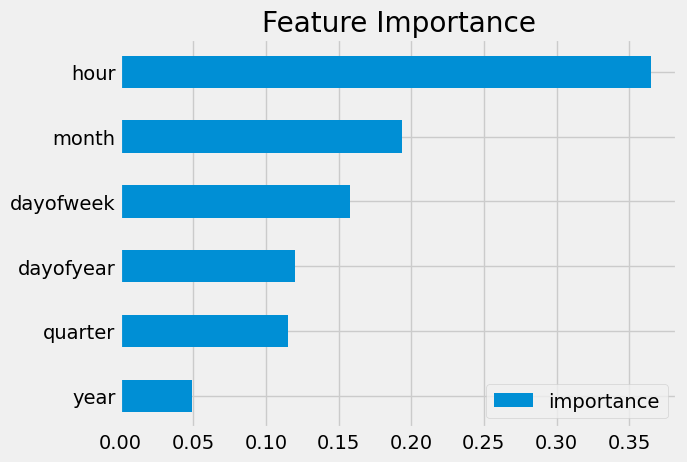

In [12]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

As expected, the most important features are hour, month, and day of week. Day of year and quarter are probably excess variables that couold be infered from the first three variables.

#Forecast on Test

In [13]:
test['prediction'] = reg.predict(X_test)
test.head()


,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,16375.0,0,3,1,1,2015,1,1,1,16409.544922
2015-01-01 01:00:00,16172.0,1,3,1,1,2015,1,1,1,15945.625000
2015-01-01 02:00:00,15968.0,2,3,1,1,2015,1,1,1,15893.853516
2015-01-01 03:00:00,15749.0,3,3,1,1,2015,1,1,1,15935.795898
2015-01-01 04:00:00,15727.0,4,3,1,1,2015,1,1,1,15935.795898


In [14]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18112.775391
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18112.775391
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17780.941406
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,31,16259.825195
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,31,14421.719727


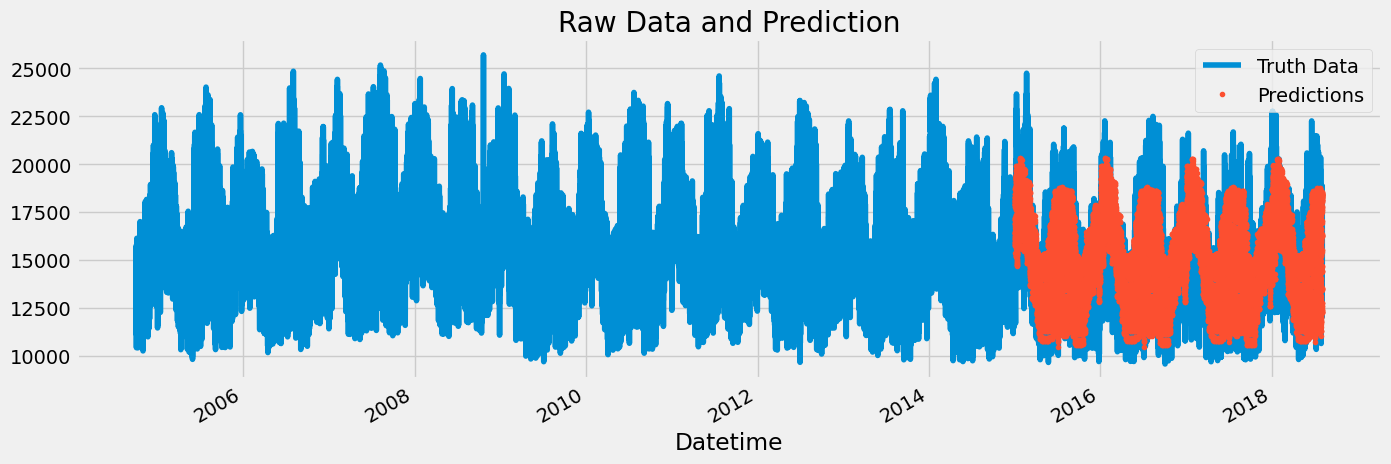

In [15]:
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

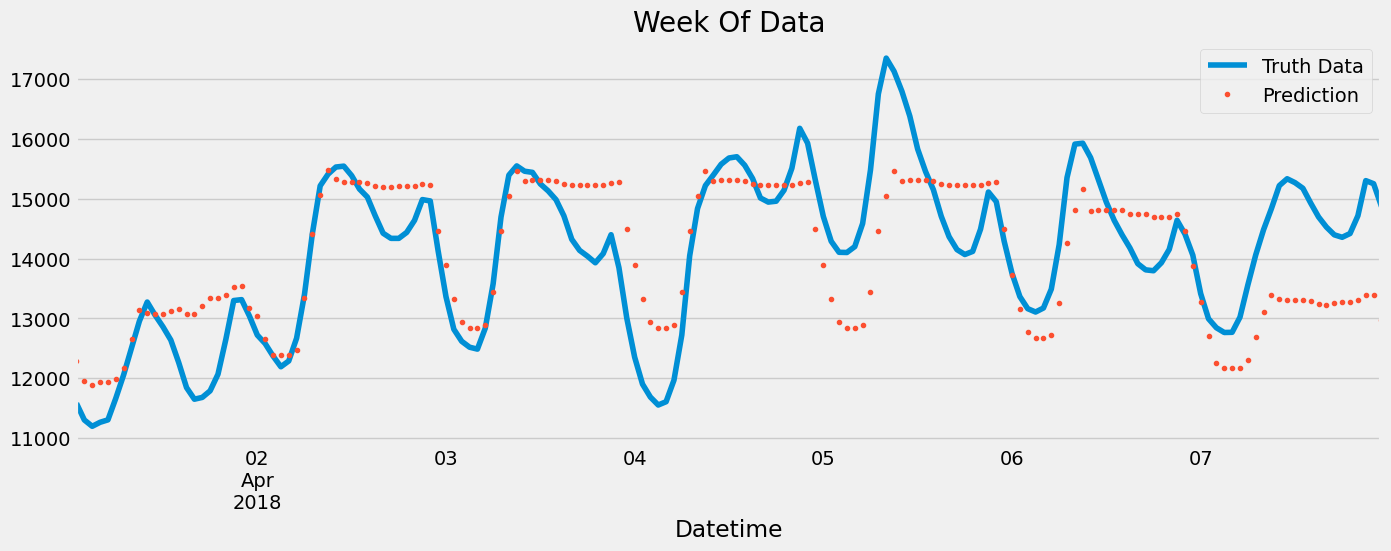

In [16]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [17]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1643.09


Aggregate the energy usage error by date and report the most inaccurate dates.

In [18]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2017-01-22,4872.108968
2015-02-20,4861.401571
2015-02-19,4769.359985
2018-01-06,4403.549683
2017-02-07,4290.881022
2018-01-07,4202.593099
2017-01-03,4168.695475
2016-02-03,4092.213298
2017-01-23,4076.364746


At this point, I will begin exploring on my own. All of the worse performing points are in the January and February. Lets look at January and February of 2017 which contains 5 of the data points.

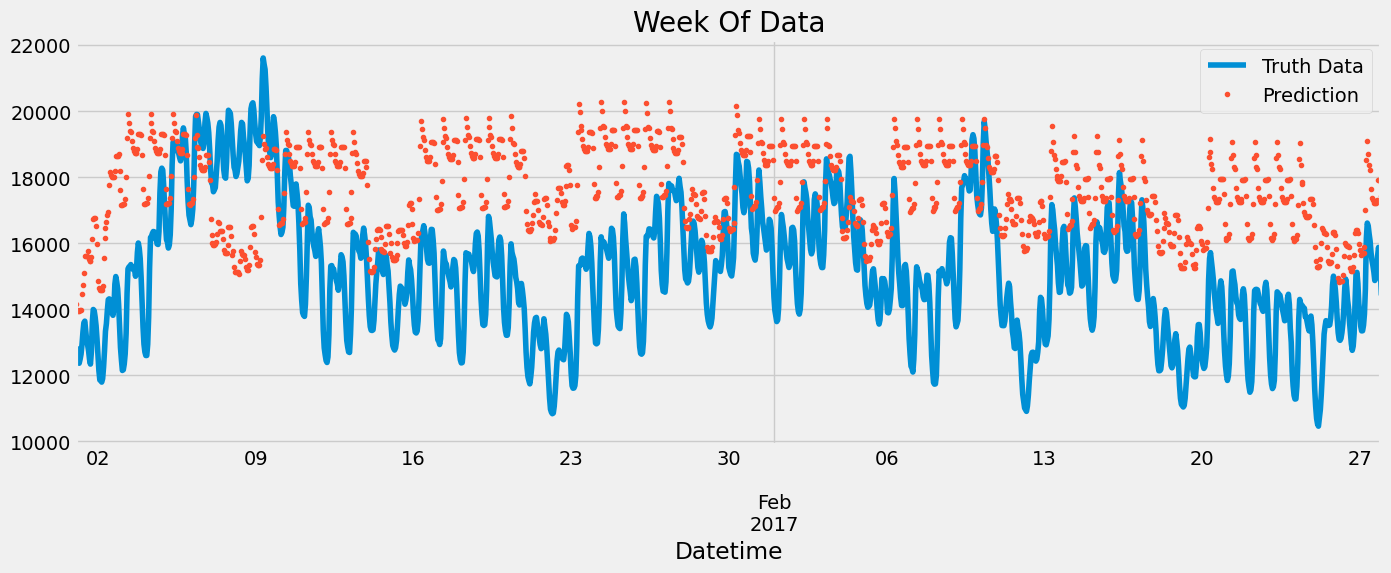

In [19]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '02-28-2017')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2017') & (df.index < '02-28-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Hmm, it looks like most of the errors are overpredictions (predicting higher energy usage than expected). Seeing that AEP is the electric utility for Ohio, I would hypothesize a significant amount of the energy usage for January and February would be related to heating homes. If there is unseasonably warm weather in January and February, we would possibly see a reduction in energy usage that would not be accruately preducted. I seem to remember (I was living in Chicago at the time) that the 2017 winter was relatively mild compared to other years.

Looking at the weather data (weather.gov) from January 2017 for Columbus, OH, the average high in January 2017 was 7 degrees greater than normal. The average low was 8 degrees greater than normal. Diving into the data further, we can see that on January 22, 2017 (highest error), the daily high was 64 deg F, 27 deg above normal. This would seem to confirm my hypothesis that the error is due to abnormally hot weather in the winter.

In terms of improving the prediction, the easiest addition would be to add a variable incorporating weather data. Based off of the exploration above, a variable tracking the difference between the expected high and the average high for the data would supply the most information.

## Part 2 follow up

There was a follow up youtube video where some of the most replied suggestions were implemented. I shall do the same. Time Series Forecasting with XGBoost - Advanced Methods https://www.youtube.com/watch?v=z3ZnOW-S550&list=WL&index=13

### 1) Outlier removal

<Axes: ylabel='Frequency'>

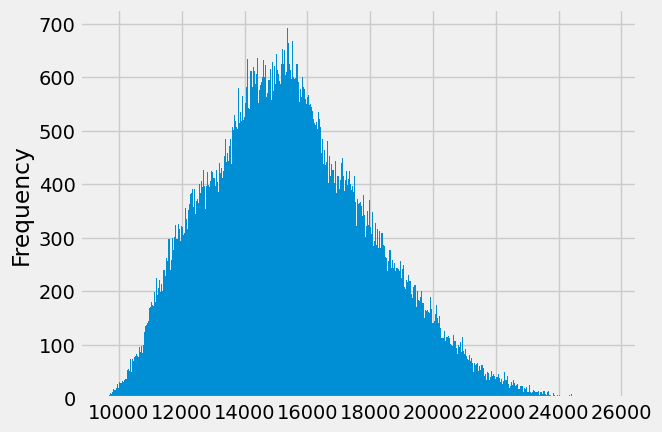

In [20]:
df['AEP_MW'].plot(kind='hist', bins=500)

In [21]:
df.query('AEP_MW > 25000')

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2007-08-08 15:00:00,25164.0,15,2,3,8,2007,220,8,32,NaN
2007-08-08 16:00:00,25056.0,16,2,3,8,2007,220,8,32,NaN
2007-08-08 17:00:00,25140.0,17,2,3,8,2007,220,8,32,NaN
2007-08-09 17:00:00,25035.0,17,3,3,8,2007,221,9,32,NaN
2008-10-20 14:00:00,25695.0,14,0,4,10,2008,294,20,43,NaN


Looking at the histogram, we can see the data has a bell curve shape. However, looking back at the full plot, we can see there seems to be one data point in 2008 ish that is much higher than the surrounding data points. Looking at the month box plot, we can see this same data point might be in October of 2008. Let's look at October of 2008.

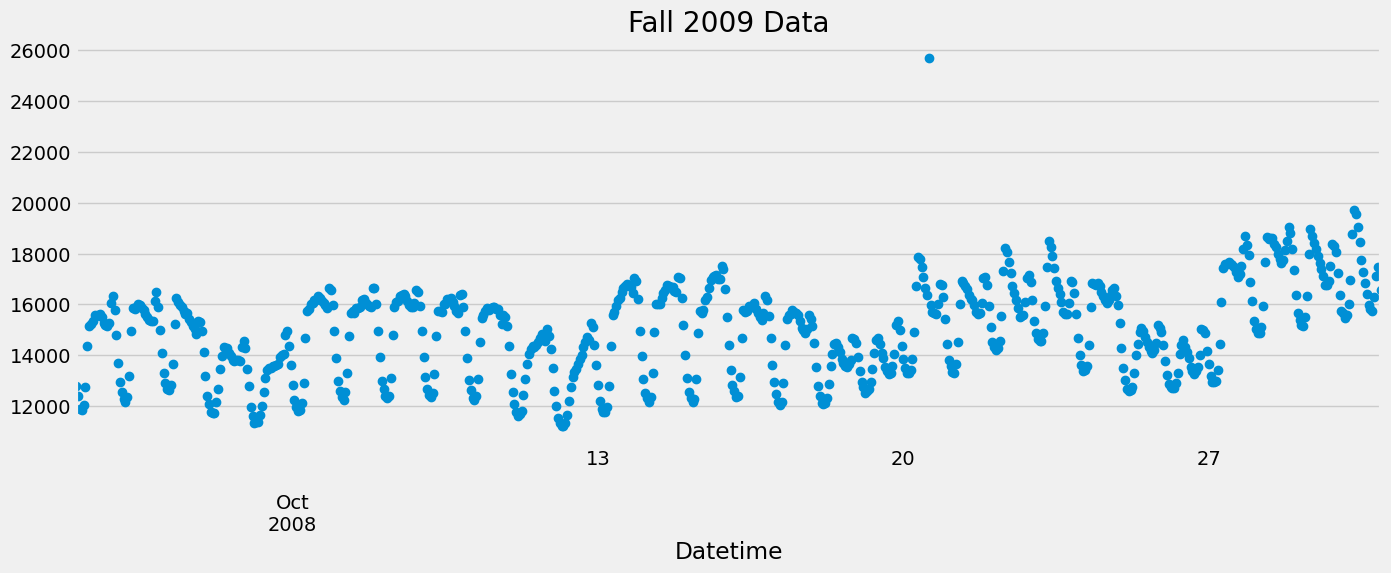

In [22]:
ax = df.loc[(df.index > '10-01-2008') & (df.index < '10-31-2008')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Fall 2009 Data', marker = 'o', linestyle='')
plt.show()

Let's remove that data point which is 33% + larger than the surrounding data. Besides that, all the other outliers seem to be around the same date range, so I will keep them.

In [23]:
df = df.query('AEP_MW < 25_500').copy()

###2) Time Series Cross-Validation

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

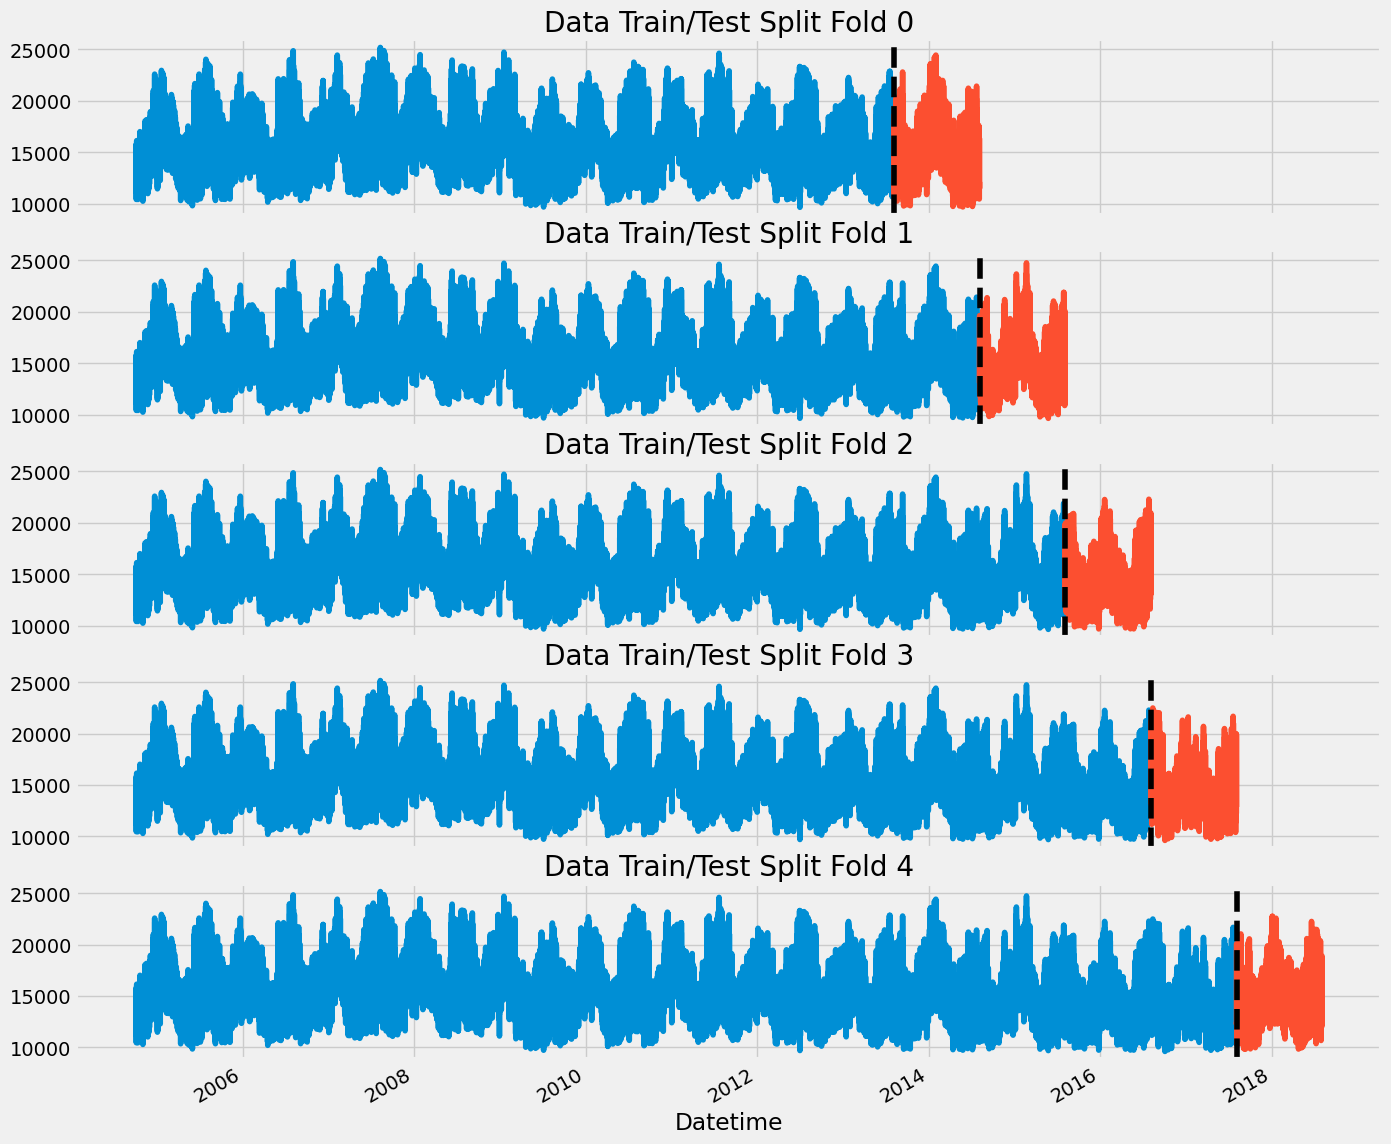

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### 3) Lag Features

In [26]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [27]:
df = add_lags(df)

Training

In [28]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:15898.03113	validation_1-rmse:15263.64389
[100]	validation_0-rmse:6031.10029	validation_1-rmse:5645.59194
[200]	validation_0-rmse:2653.98825	validation_1-rmse:2426.91728
[300]	validation_0-rmse:1707.08329	validation_1-rmse:1644.72726
[400]	validation_0-rmse:1489.80648	validation_1-rmse:1551.11461
[462]	validation_0-rmse:1446.49648	validation_1-rmse:1553.94478
[0]	validation_0-rmse:15834.99651	validation_1-rmse:15222.40367
[100]	validation_0-rmse:6007.58253	validation_1-rmse:5715.60355
[200]	validation_0-rmse:2645.16579	validation_1-rmse:2504.38734
[300]	validation_0-rmse:1707.50979	validation_1-rmse:1616.55439
[400]	validation_0-rmse:1500.85941	validation_1-rmse:1452.26766
[500]	validation_0-rmse:1442.28701	validation_1-rmse:1428.93763
[600]	validation_0-rmse:1410.76972	validation_1-rmse:1428.32590
[627]	validation_0-rmse:1404.56989	validation_1-rmse:1428.86707
[0]	validation_0-rmse:15778.90821	validation_1-rmse:14549.79005
[100]	validation_0-rmse:5985.23715	valid

In [29]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1564.0351
Fold scores:[np.float64(1550.4603694031152), np.float64(1427.667855316764), np.float64(1499.9665274669187), np.float64(1645.4343196934153), np.float64(1696.646615156534)]


###3.1) Weather data

In order to see how the addition of weather data will affect the performance, I will add it instead of the lag data and see the performance of the data

In [30]:
pip install meteostat

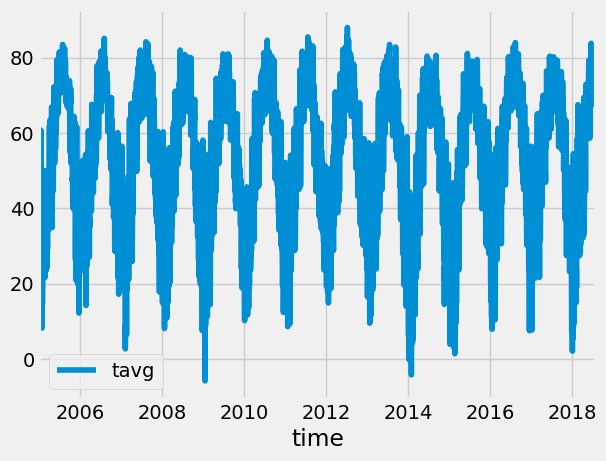

In [31]:
from datetime import datetime
from meteostat import Point, Daily, units

# Define the time period
start = datetime(2004, 1, 1)
end = datetime(2018, 8, 3)

# Latitude and Longitude of Columbus, OH, USA
location = Point(40, -83)

# Get daily data for the specified location and time period
data = Daily(location, start, end)

# Convert data to imperial units if desired (optional)
data = data.convert(units.imperial)

# Fetch the data
daily_temp_df = data.fetch()

daily_temp_df.plot(y=['tavg'])
plt.show()

In [32]:
print(daily_temp_df.head(1))
print(daily_temp_df.tail(1))

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
time                                                                  
2005-01-01  50.2  48.2  51.8   NaN   NaN  <NA>   3.9   NaN  <NA>  <NA>
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2018-08-03  75.0  64.0  84.9   0.0   NaN  <NA>   4.2   NaN  1018.1  <NA>


Looks like the weather data only goes back to January 1, 2005. That's ok. I will just use data from 2005 on for this test

In [33]:
df_weather = df.loc[df.index >= '01-01-2005']
df_weather.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2005-01-01 00:00:00,12892.0,0,5,1,1,2005,1,1,53,NaN,NaN,NaN,NaN
2005-01-01 01:00:00,12316.0,1,5,1,1,2005,1,1,53,NaN,NaN,NaN,NaN
2005-01-01 02:00:00,11890.0,2,5,1,1,2005,1,1,53,NaN,NaN,NaN,NaN
2005-01-01 03:00:00,11579.0,3,5,1,1,2005,1,1,53,NaN,NaN,NaN,NaN
2005-01-01 04:00:00,11461.0,4,5,1,1,2005,1,1,53,NaN,NaN,NaN,NaN


Now we need to add the average daily temperature data to the energy data. Since the energy data is hourly, I will resample it to hourly data and use forward fill to use the average temperature for the entire day.

In [34]:
# Resample daily temperature data to hourly using forward-fill
hourly_temp_df = daily_temp_df['tavg'].resample('H').ffill()

print("\nUpsampled Hourly Temperature Data (First 5 rows):")
print(hourly_temp_df.head())


Upsampled Hourly Temperature Data (First 5 rows):
time
2005-01-01 00:00:00    50.2
2005-01-01 01:00:00    50.2
2005-01-01 02:00:00    50.2
2005-01-01 03:00:00    50.2
2005-01-01 04:00:00    50.2
Freq: h, Name: tavg, dtype: float64


In [35]:
merged_df = pd.merge(df_weather, hourly_temp_df, left_index=True, right_index=True)
merged_df.tail()
#merged_df = df_weather.merge(hourly_temp_df, on='datetime', how='left')

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3,tavg
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18112.775391,18705.0,20140.0,16078.0,72.7
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18112.775391,18108.0,19616.0,15908.0,72.7
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17780.941406,17544.0,19246.0,15783.0,72.7
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,31,16259.825195,16262.0,17943.0,14808.0,72.7
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,31,14421.719727,15045.0,16491.0,13669.0,75.0


Let's run the training on the data. I will train the first model on only the date time feature. I will then add the average temperature to the second model to see it's impact.

In [36]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
merged_df = merged_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(merged_df):
    train = merged_df.iloc[train_idx]
    test = merged_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

[0]	validation_0-rmse:15919.32529	validation_1-rmse:15260.09387
[100]	validation_0-rmse:6074.77797	validation_1-rmse:5468.97507
[200]	validation_0-rmse:2708.94876	validation_1-rmse:2331.44146
[300]	validation_0-rmse:1734.90622	validation_1-rmse:1690.16608
[400]	validation_0-rmse:1494.47518	validation_1-rmse:1637.37576
[500]	validation_0-rmse:1412.82265	validation_1-rmse:1631.22793
[600]	validation_0-rmse:1370.01671	validation_1-rmse:1615.88885
[700]	validation_0-rmse:1341.55411	validation_1-rmse:1603.03996
[800]	validation_0-rmse:1317.63729	validation_1-rmse:1581.00706
[900]	validation_0-rmse:1298.33594	validation_1-rmse:1566.90554
[999]	validation_0-rmse:1284.71780	validation_1-rmse:1562.21287
[0]	validation_0-rmse:15852.55221	validation_1-rmse:15217.40241
[100]	validation_0-rmse:6054.82674	validation_1-rmse:5450.63577
[200]	validation_0-rmse:2713.59735	validation_1-rmse:2315.61490
[300]	validation_0-rmse:1760.13594	validation_1-rmse:1622.84965
[400]	validation_0-rmse:1522.47684	valid

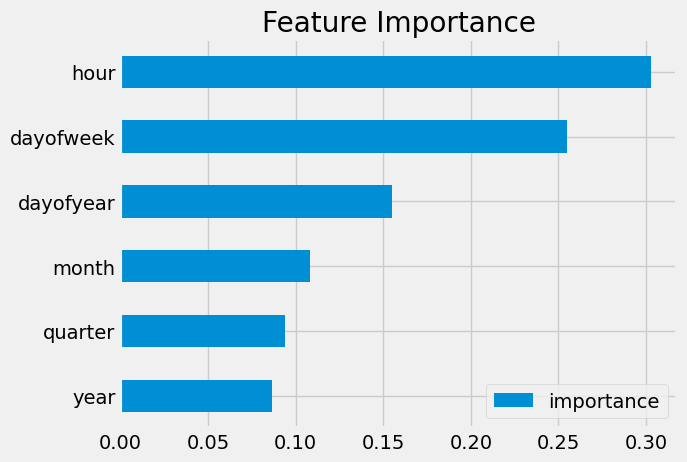

In [37]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
merged_df = merged_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(merged_df):
    train = merged_df.iloc[train_idx]
    test = merged_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'tavg']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

[0]	validation_0-rmse:15918.68939	validation_1-rmse:15259.40198
[100]	validation_0-rmse:5990.80751	validation_1-rmse:5289.59651
[200]	validation_0-rmse:2491.29233	validation_1-rmse:1906.08593
[300]	validation_0-rmse:1398.80560	validation_1-rmse:1179.41119
[400]	validation_0-rmse:1103.08122	validation_1-rmse:1123.56388
[500]	validation_0-rmse:1006.90660	validation_1-rmse:1104.13707
[600]	validation_0-rmse:952.06116	validation_1-rmse:1078.57792
[700]	validation_0-rmse:912.94214	validation_1-rmse:1051.89889
[800]	validation_0-rmse:885.61288	validation_1-rmse:1028.67841
[900]	validation_0-rmse:865.04234	validation_1-rmse:1008.45931
[999]	validation_0-rmse:848.67355	validation_1-rmse:988.21122
[0]	validation_0-rmse:15851.94636	validation_1-rmse:15216.31490
[100]	validation_0-rmse:5973.14599	validation_1-rmse:5286.63352
[200]	validation_0-rmse:2494.59685	validation_1-rmse:1929.88132
[300]	validation_0-rmse:1415.77456	validation_1-rmse:1176.70316
[400]	validation_0-rmse:1126.87075	validation_

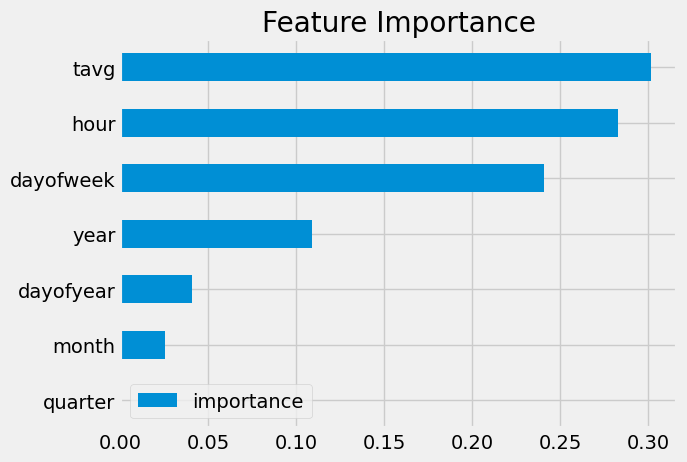

In [39]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

As expected, the average temperature was an important feature, reducing the rmse by ~40%. It also became the most important feature, replacing hour of day. Let's see the final prediction.

In [40]:
test['prediction'] = reg.predict(X_test)
merged_df = merged_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
merged_df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,lag1,lag2,lag3,tavg,prediction_y
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18112.775391,18705.0,20140.0,16078.0,72.7,17761.755859
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18112.775391,18108.0,19616.0,15908.0,72.7,17746.158203
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17780.941406,17544.0,19246.0,15783.0,72.7,17422.464844
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,31,16259.825195,16262.0,17943.0,14808.0,72.7,16203.428711
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,31,14421.719727,15045.0,16491.0,13669.0,75.0,15054.704102


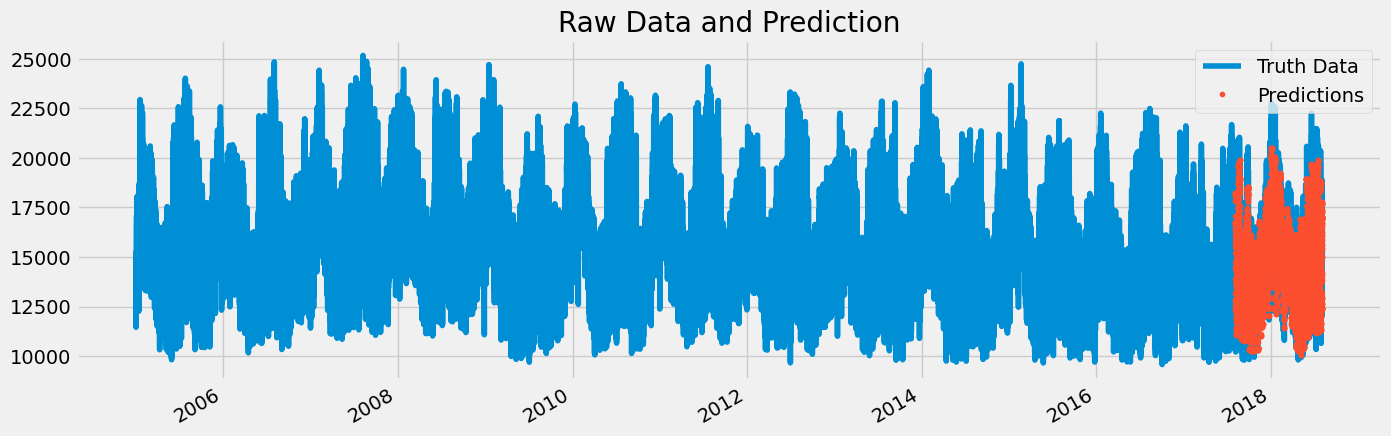

In [41]:
ax = merged_df[['AEP_MW']].plot(figsize=(15, 5))
merged_df['prediction_y'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

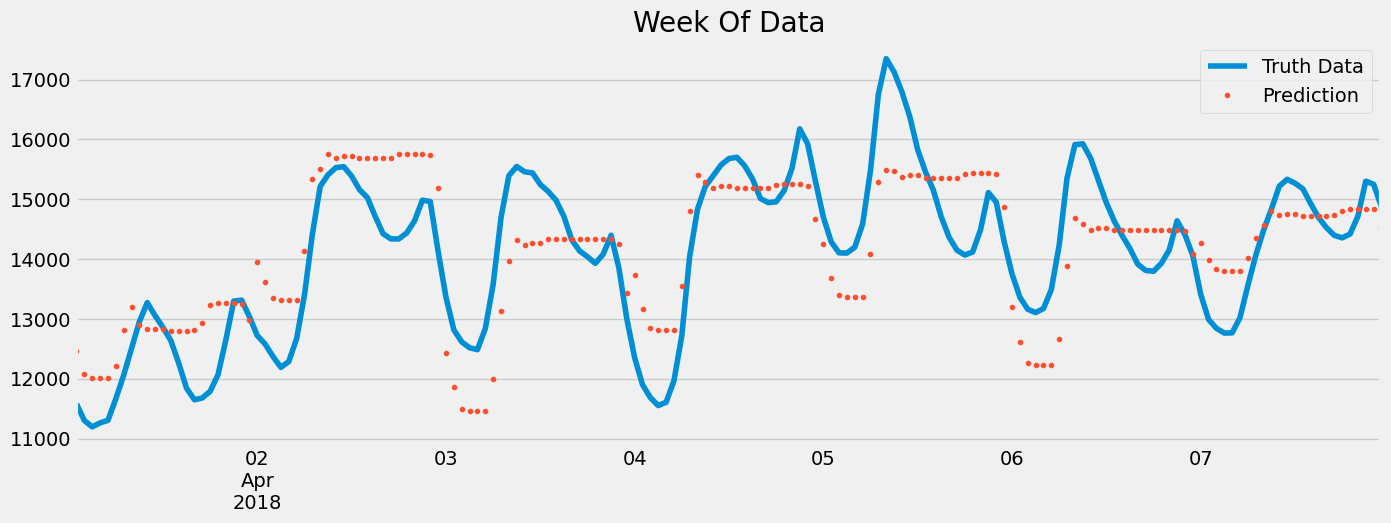

In [42]:
ax = merged_df.loc[(merged_df.index > '04-01-2018') & (merged_df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
merged_df.loc[(merged_df.index > '04-01-2018') & (merged_df.index < '04-08-2018')]['prediction_y'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [43]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2017-09-04,1932.311523
2018-01-05,1882.234863
2017-12-25,1881.235270
2018-01-08,1874.117350
2018-01-07,1865.508382
2017-11-23,1720.531982
2018-04-24,1702.335693
2018-07-01,1604.843709
2018-01-18,1557.129801


###4) Future Prediction

In [44]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:15558.69835
[100]	validation_0-rmse:5908.65263
[200]	validation_0-rmse:2622.39482
[300]	validation_0-rmse:1721.87521
[400]	validation_0-rmse:1523.74705
[499]	validation_0-rmse:1472.30123


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [46]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [47]:
future_w_features = df_and_future.query('isFuture').copy()

Prediction

In [48]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

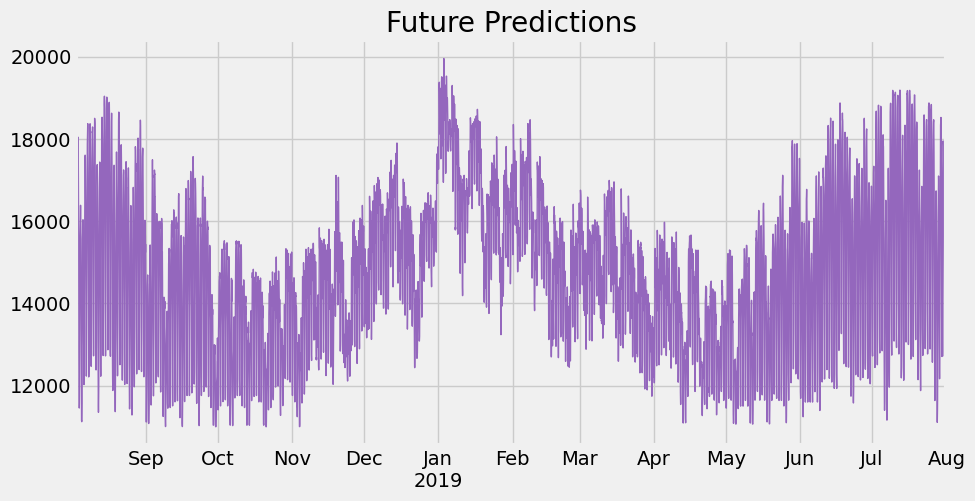

In [49]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

<Axes: title={'center': 'New year Data'}>

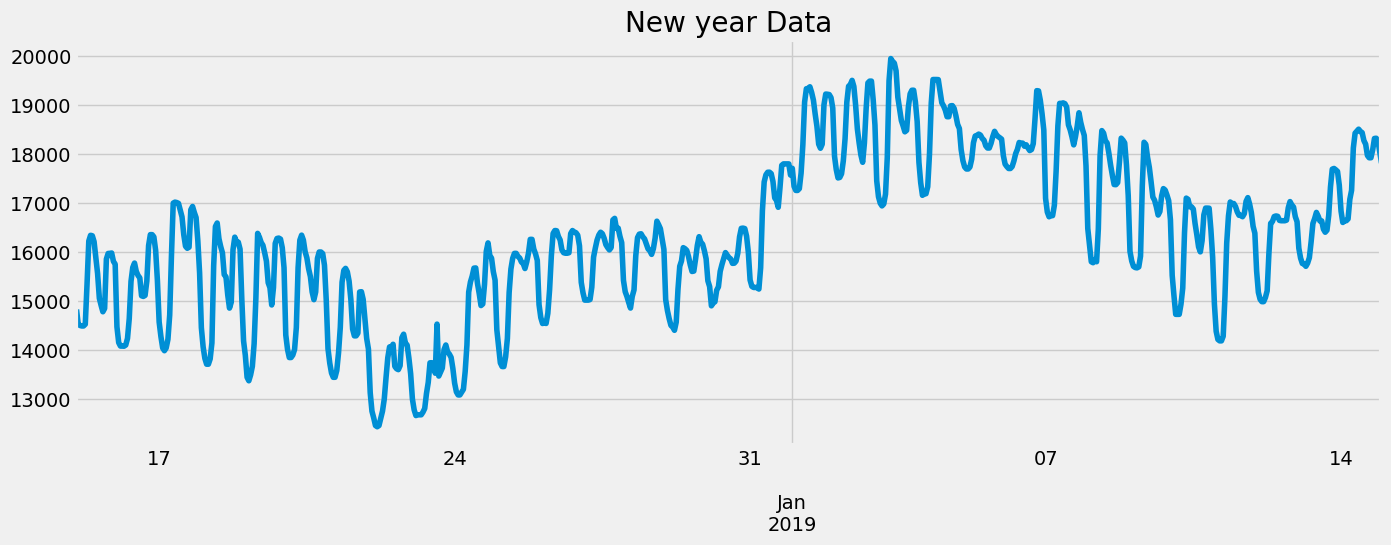

In [50]:
future_w_features['pred'].loc[(future_w_features.index > '12-15-2018') & (future_w_features.index < '01-15-2019')] \
    .plot(figsize=(15, 5), title='New year Data')

##Facebook Prophet Model

Learning to use Facebook's Prophet Model which is an additive model

In [51]:
pip install prophet

Not sure why but there seems to be an issue with running the prophet model due to updates with the cmdstanpy library. Online comments suggested reverting to an older version fixes the issue

In [52]:
pip uninstall cmdstanpy

Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Would remove:
    /usr/local/bin/install_cmdstan
    /usr/local/bin/install_cxx_toolchain
    /usr/local/lib/python3.12/dist-packages/cmdstanpy-1.3.0.dist-info/*
    /usr/local/lib/python3.12/dist-packages/cmdstanpy/*
Proceed (Y/n)? Y
  Successfully uninstalled cmdstanpy-1.3.0


In [53]:
pip install cmdstanpy==1.2.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 2.7 MB/s eta 0:00:00


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


###Time Series Feature

In [62]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['weekday'] = df.index.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date_offset'] = (df.index.month*100 + df.index.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label = 'AEP_MW')
features_and_target = pd.concat([X, y], axis=1)

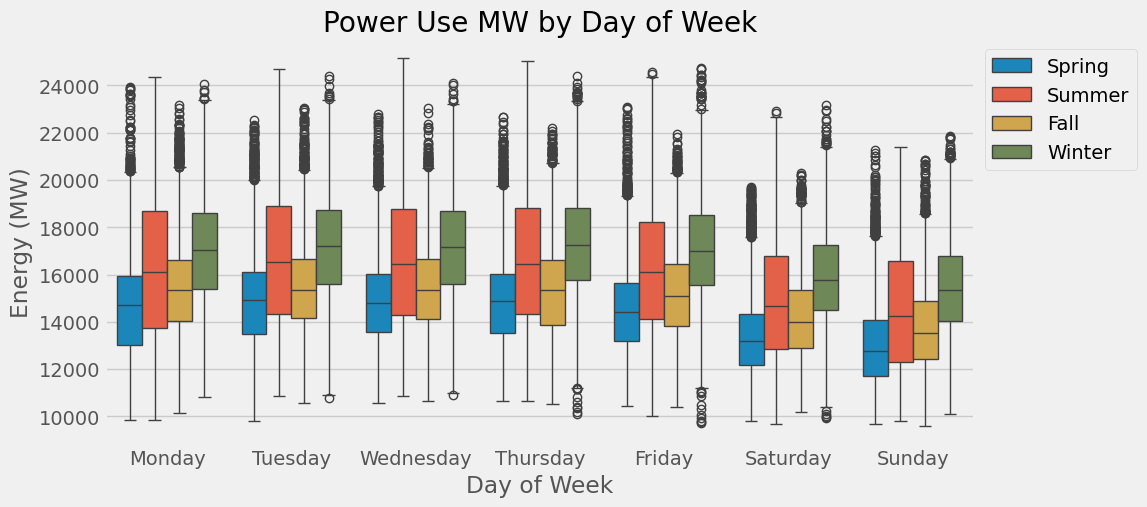

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='AEP_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

###Train/Test Split

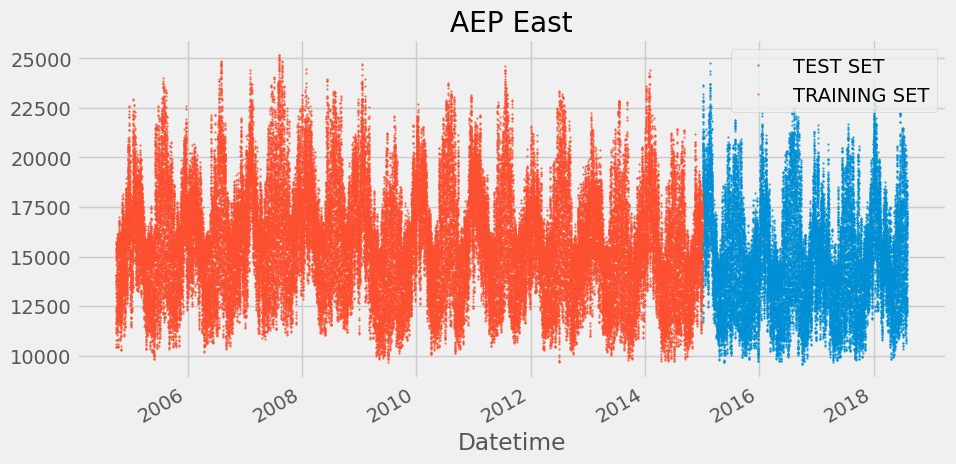

In [68]:
split_date = '1-Jan-2015'
df_reduced = df[['AEP_MW']]
df_train = df_reduced.loc[df_reduced.index <= split_date].copy()
df_test = df_reduced.loc[df_reduced.index > split_date].copy()

# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(df_train.rename(columns={'AEP_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='AEP East', style='.', ms=1)
plt.show()

Simple Prophet Model

In [69]:
from prophet import Prophet

In [70]:
# Format data for prophet model using ds and y
aep_train_prophet = df_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'AEP_MW':'y'})

In [71]:
model = Prophet()
model.fit(aep_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdcaroigl/hnn68k0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdcaroigl/95wy_q0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46069', 'data', 'file=/tmp/tmpdcaroigl/hnn68k0i.json', 'init=/tmp/tmpdcaroigl/95wy_q0y.json', 'output', 'file=/tmp/tmpdcaroigl/prophet_modelyl2j6n78/prophet_model-20251030191451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [72]:
# Predict on test set with model
aep_test_prophet = df_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'AEP_MW':'y'})

aep_test_fcst = model.predict(aep_test_prophet)

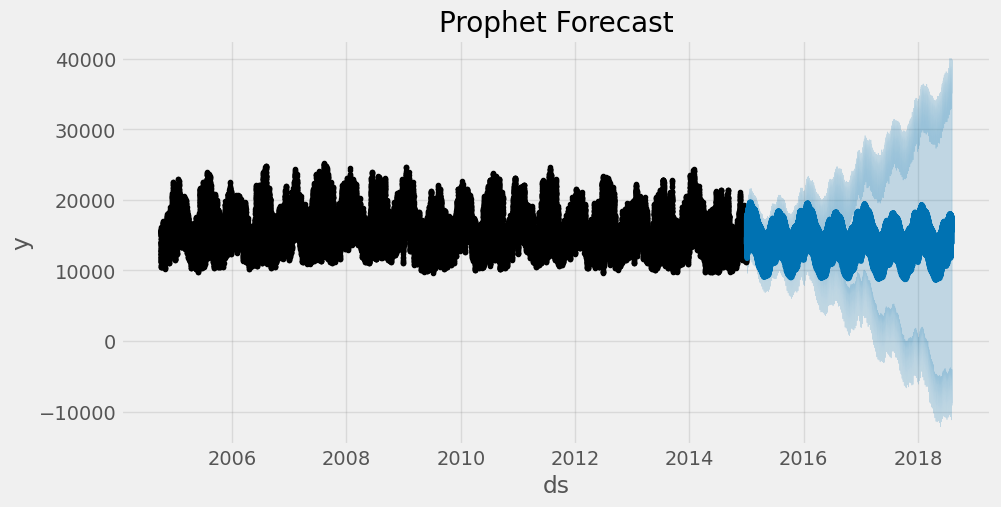

In [73]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(aep_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

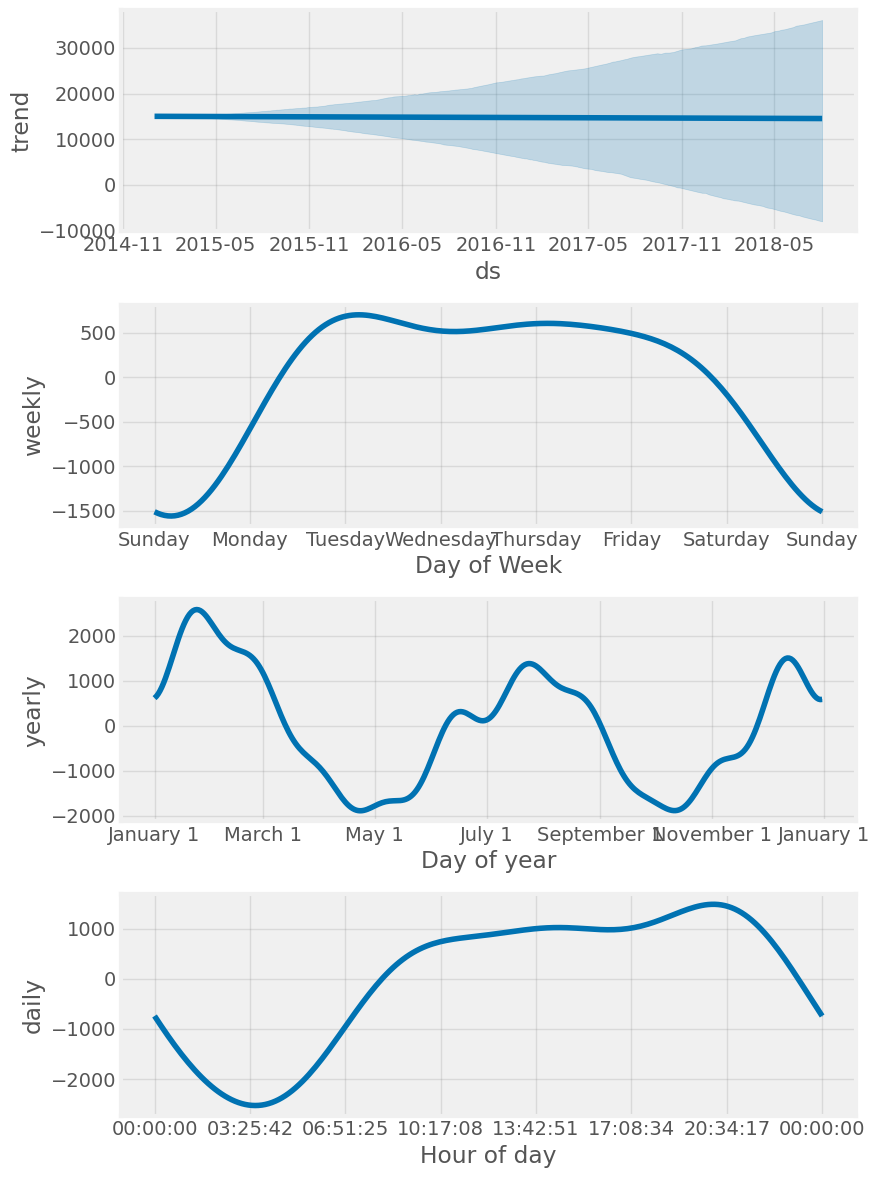

In [74]:
fig = model.plot_components(aep_test_fcst)
plt.show()

###Comparison to actual data

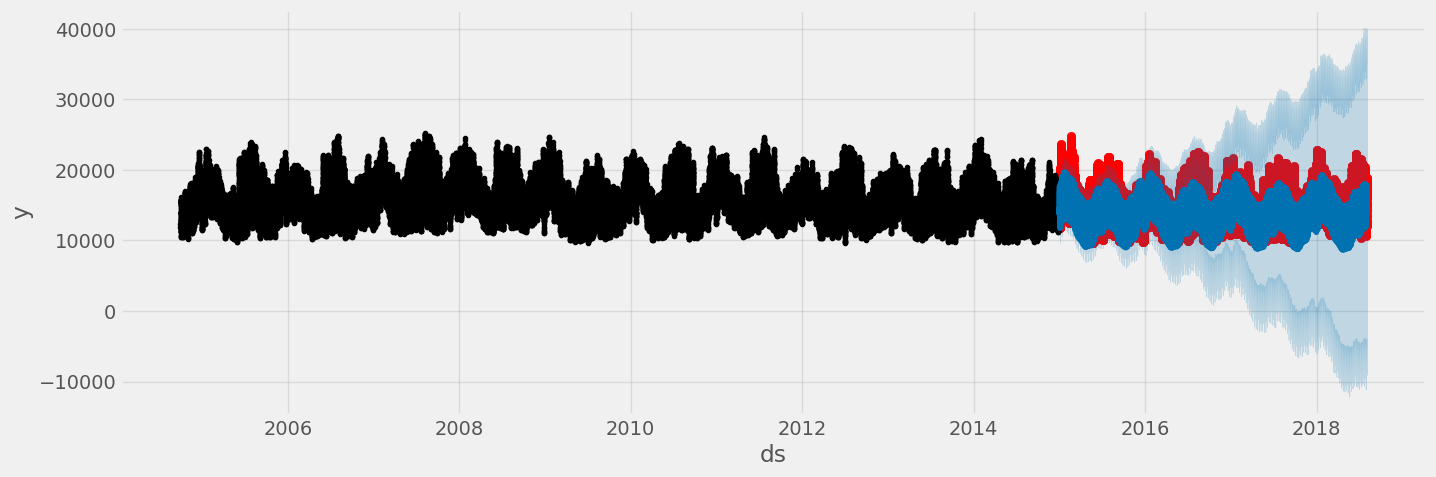

In [75]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['AEP_MW'], color='r')
fig = model.plot(aep_test_fcst, ax=ax)

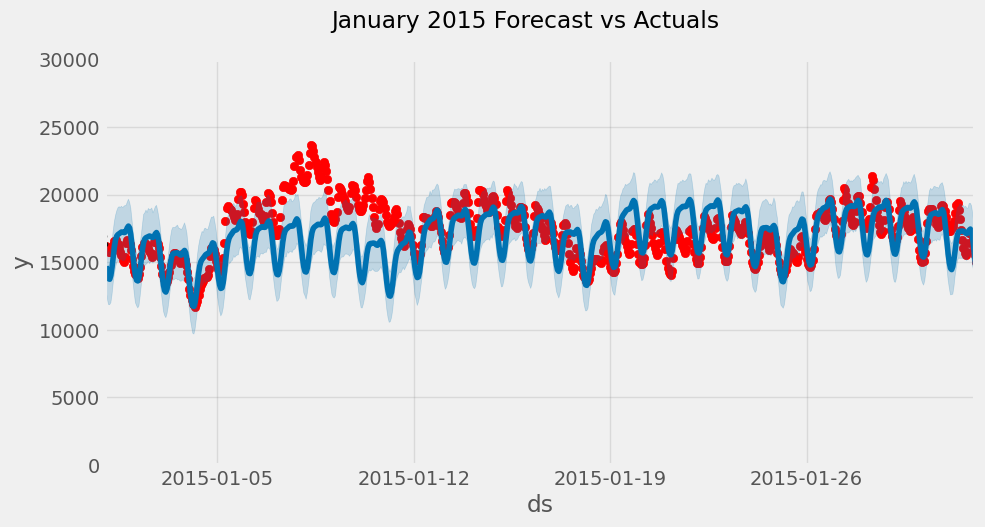

In [76]:
import datetime
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['AEP_MW'], color='r')
fig = model.plot(aep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime(2015, 1, 1),
              upper=datetime.datetime( 2015, 2, 1))
ax.set_ylim(0, 30000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

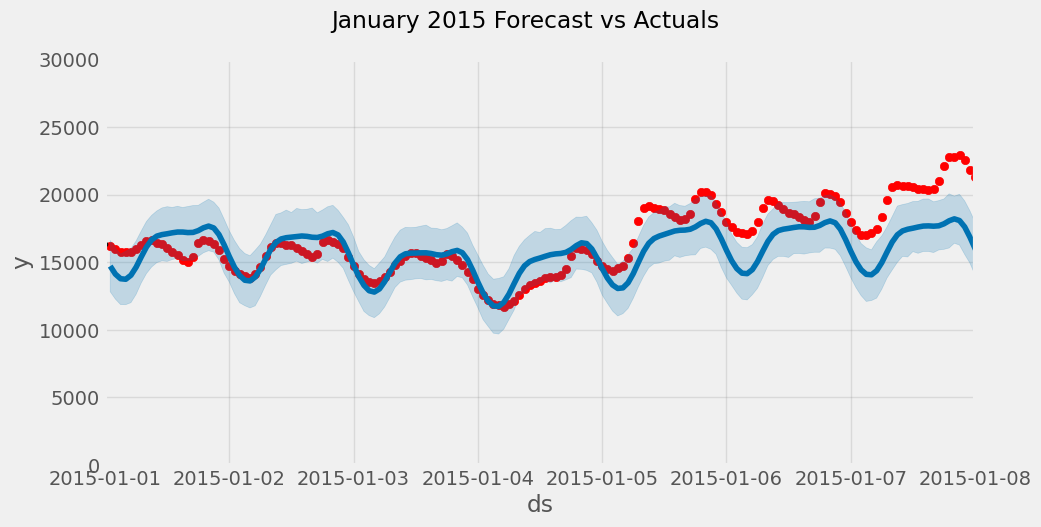

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test.index, df_test['AEP_MW'], color='r')
fig = model.plot(aep_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime(2015, 1, 1),
              upper=datetime.datetime( 2015, 1, 8))
ax.set_ylim(0, 30000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [78]:
mean_absolute_percentage_error(y_true=df_test['AEP_MW'],
                   y_pred=aep_test_fcst['yhat'])

np.float64(8.873502875710972)

In [81]:
np.sqrt(mean_squared_error(y_true=df_test['AEP_MW'],
                   y_pred=aep_test_fcst['yhat']))

np.float64(1746.451672742233)

In [79]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model.predict(future)

In [80]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,14702.440778
1,2015-01-01 02:00:00,14107.665198
2,2015-01-01 03:00:00,13766.530165
3,2015-01-01 04:00:00,13728.390530
4,2015-01-01 05:00:00,14025.253407


In terms of performance, the prophet model did not do better than the xgboost. However, the breakdown of the individual components of the model does make it more interpretable which is an advantage for potential future use.

In [ ]:
%%shell
jupyter nbconvert --to html /content/ts_machineLearning_energy.ipynb

[NbConvertApp] WARNING | pattern '/content/ts_machineLearning_energy.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_

CalledProcessError: Command 'jupyter nbconvert --to html /content/ts_machineLearning_energy.ipynb
' returned non-zero exit status 255.